In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tifffile
import numpy as np

save_dir = r"C:\Users\plots"
save_name=r"Ion_blink_8_1.png"
os.makedirs(save_dir, exist_ok=True)

Total pages: 10108


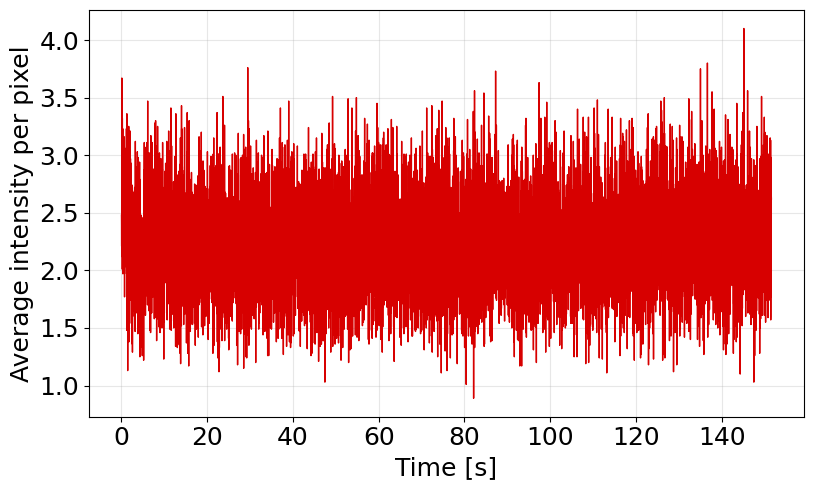

In [5]:
# ---- File path ----
tiff_path = r"Z:\barium\blink1_0.tif"
# ---- Storage for intensities ----
intensity_sum = []

# ---- Read TIFF stack ----
with tifffile.TiffFile(tiff_path) as tif:
    n_pages = len(tif.pages)
    print(f"Total pages: {n_pages}")

    for i in range(n_pages):
        img = tif.pages[i].asarray()

        # x=1–5, y=1–5  (Python is 0-indexed!)
        # So this corresponds to indices 0:5
        # roi = img[0:10, 47:57]
        roi = img[4:8, 50:54]

        total_intensity = np.sum(roi)
        intensity_sum.append(total_intensity)

intensity_sum = np.array(intensity_sum)

# ---- Plot ----
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, n_pages+1)*30/2000, intensity_sum/100, lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Average intensity per pixel")
# plt.title("Sum of Pixel Intensity (x=1–5, y=1–5)")
# plt.xlim(0,0.2)
plt.grid(alpha=0.3)
plt.tight_layout()
# save_path = os.path.join(save_dir, "Ion_blink_3.png")
# plt.savefig(save_path, dpi=300)
plt.show()


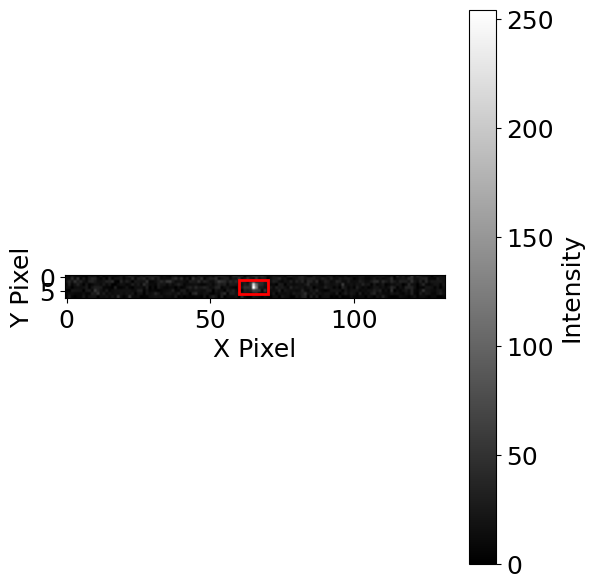

In [6]:
from matplotlib.patches import Rectangle

# ---- Read first page ----
with tifffile.TiffFile(tiff_path) as tif:
    img = tif.pages[20].asarray()   # page 1 (index 0)

# ---- Define ROI ----
# Pixels 1–5 in x and y → Python indices 0:5
x_start, x_end = 60, 70
y_start, y_end = 1, 6

# ---- Plot ----
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(img, cmap='gray')
plt.colorbar(im, ax=ax, label='Intensity')

# Draw rectangle around ROI
rect = Rectangle(
    (x_start, y_start),          # bottom-left corner
    x_end - x_start,             # width
    y_end - y_start,             # height
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)

# ax.set_title("First Page with 5×5 ROI (x=1–5, y=1–5)")
ax.set_xlabel("X Pixel")
ax.set_ylabel("Y Pixel")

plt.tight_layout()
plt.show()


Total pages: 10108
Raw mean duration: 13.625
Raw mean duration: 98.64044943820225
Dark:   p = 0.101412 ± 0.010816 per frame
Bright: p = 0.015849 ± 0.001828 per frame
Dark rate:   6.761 ± 0.721 s^-1
Bright rate: 1.057 ± 0.122 s^-1
13.625 98.64044943820225
Saved: C:\Users\jxwan\OneDrive\Documents\Python Scripts\UCLA_code\plots\Ion_blink_8_1.png


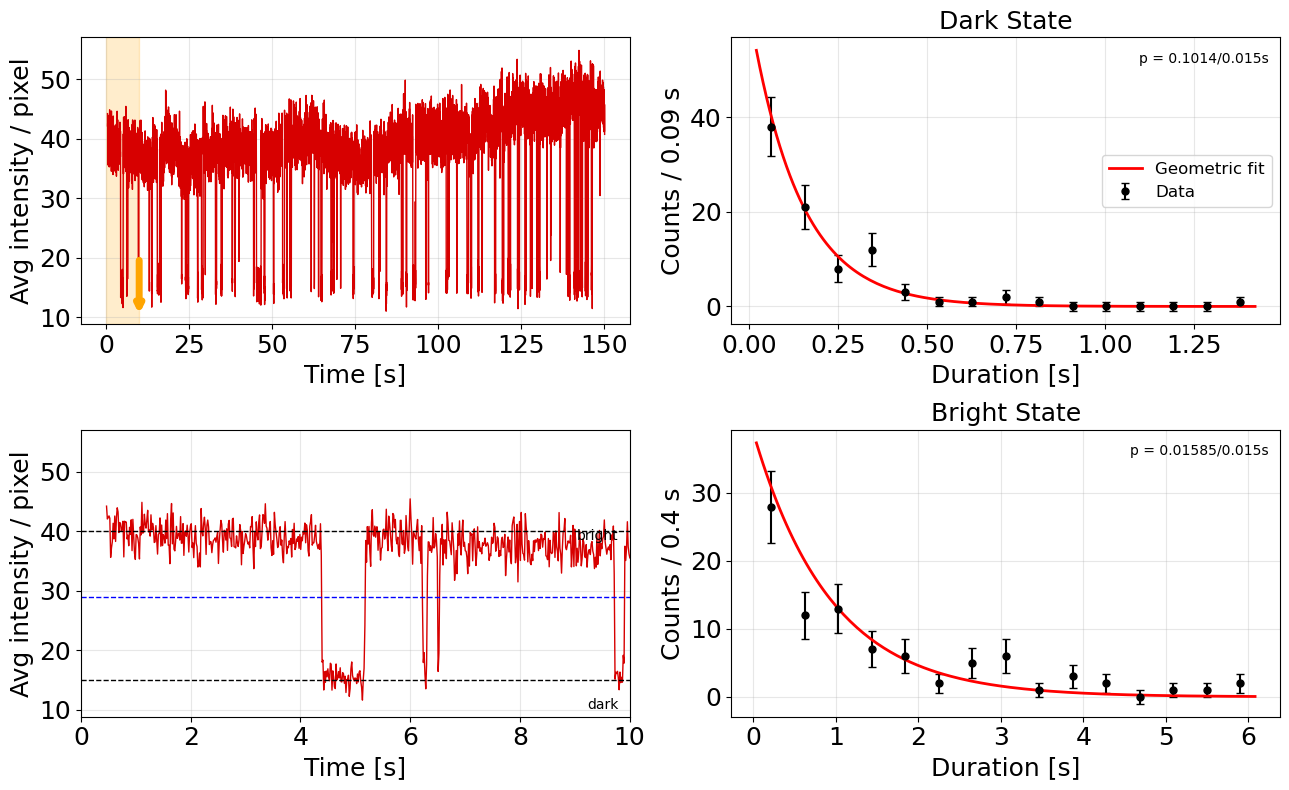

In [20]:
tiff_path = r"Z:\barium\blink1_0.tif"
threshold = 1450
n_bins = 15
frame_time = 30 / 2000  # seconds per frame (your convention)

# =============================
# LOAD TIFF -> intensity_sum
# =============================
intensity_sum = []
with tifffile.TiffFile(tiff_path) as tif:
    n_pages = len(tif.pages)
    print(f"Total pages: {n_pages}")

    for i in range(n_pages):
        img = tif.pages[i].asarray()
        roi = img[1:6, 60:70]
        intensity_sum.append(np.sum(roi))

intensity_sum = np.array(intensity_sum)[30:-100]
t_s = np.arange(1, n_pages + 1)[30:-100] * frame_time  # your original convention
y_plot = intensity_sum / 50.0

# ============================================================
# (RIGHT COLUMN) EXACTLY YOUR LIFETIME CODE, but as functions
# ============================================================

def get_run_lengths(mask: np.ndarray) -> np.ndarray:
    mask = np.asarray(mask, dtype=bool)
    runs = []
    current = 0
    for v in mask:
        if v:
            current += 1
        else:
            if current > 0:
                runs.append(current)
                current = 0
    if current > 0:
        runs.append(current)
    return np.array(runs, dtype=int)

def fit_geometric_p(durations: np.ndarray) -> tuple[float, float, float]:
    durations = np.asarray(durations, dtype=float)
    mean_val = np.mean(durations)
    print("Raw mean duration:", mean_val)

    # keep only durations < 2 × mean (your truncation)
    durations = durations[durations < 2 * mean_val]

    if durations.size == 0:
        raise ValueError("durations is empty; check threshold or data.")

    mean_d = np.mean(durations)
    if mean_d <= 0:
        raise ValueError("Mean duration is non-positive.")

    p_hat = 1.0 / mean_d
    p_hat = float(np.clip(p_hat, 1e-12, 1 - 1e-12))

    N = durations.size

    # NLL (your original)
    nll = -(N * np.log(p_hat) +
            np.sum((durations - 1.0) * np.log(1.0 - p_hat)))

    # --- analytic standard error ---
    sigma_p = np.sqrt(p_hat**2 * (1 - p_hat) / N)

    return p_hat, sigma_p, float(nll)


def geometric_bin_prob(p: float, a: float, b: float) -> float:
    t_min = int(np.ceil(a))
    t_max = int(np.floor(b - 1e-12))
    if t_max < t_min:
        return 0.0
    q = 1.0 - p
    return float(q ** (t_min - 1) - q ** (t_max))

def expected_counts_per_bins(p: float,
                             durations: np.ndarray,
                             bins: np.ndarray,
                             continuous: bool = True) -> np.ndarray:
    durations = np.asarray(durations)
    bins = np.asarray(bins, dtype=float)
    if bins.ndim != 1 or bins.size < 2:
        raise ValueError("bins must be 1D with at least 2 edges.")

    N = durations.size
    mu = np.zeros(bins.size - 1, dtype=float)

    if continuous:
        lam = -np.log(1.0 - p)
        for i in range(bins.size - 1):
            a = bins[i]
            b = bins[i + 1]
            prob = (p / lam) * (np.exp(-(a - 1) * lam) - np.exp(-(b - 1) * lam))
            mu[i] = N * prob
    else:
        q = 1.0 - p
        for i in range(bins.size - 1):
            a = bins[i]
            b = bins[i + 1]
            t_min = int(np.ceil(a))
            t_max = int(np.floor(b - 1e-12))
            if t_max >= t_min:
                prob = q**(t_min - 1) - q**(t_max)
                mu[i] = N * prob
    return mu

def plot_dark_bright_runlengths_on_axes(intensity_sum: np.ndarray,
                                       ax_dark,
                                       ax_bright,
                                       threshold: float = 2500,
                                       n_bins: int = 15) -> None:
    intensity_sum = np.asarray(intensity_sum)
    if intensity_sum.ndim != 1:
        raise ValueError("intensity_sum must be a 1D array (one value per frame).")

    dark_mask = intensity_sum < threshold
    bright_mask = intensity_sum >= threshold

    dark_durations = get_run_lengths(dark_mask)
    bright_durations = get_run_lengths(bright_mask)

    if dark_durations.size == 0:
        raise ValueError("No dark runs found. Try raising threshold or check data.")
    if bright_durations.size == 0:
        raise ValueError("No bright runs found. Try lowering threshold or check data.")

    p_dark, sigma_dark, _ = fit_geometric_p(dark_durations)
    p_bright, sigma_bright, _ = fit_geometric_p(bright_durations)

    print(f"Dark:   p = {p_dark:.6f} ± {sigma_dark:.6f} per frame")
    print(f"Bright: p = {p_bright:.6f} ± {sigma_bright:.6f} per frame")
    
    print(f"Dark rate:   {p_dark/frame_time:.3f} ± {sigma_dark/frame_time:.3f} s^-1")
    print(f"Bright rate: {p_bright/frame_time:.3f} ± {sigma_bright/frame_time:.3f} s^-1")

    
    bins_dark = np.linspace(1, dark_durations.max() + 1, n_bins + 1)
    bins_bright = np.linspace(1, bright_durations.max() + 1, n_bins + 1)

    dark_counts, _ = np.histogram(dark_durations, bins=bins_dark)
    bright_counts, _ = np.histogram(bright_durations, bins=bins_bright)

    bin_centers_dark = 0.5 * (bins_dark[:-1] + bins_dark[1:])
    bin_centers_bright = 0.5 * (bins_bright[:-1] + bins_bright[1:])

    dark_err = np.sqrt(np.maximum(dark_counts, 1))
    bright_err = np.sqrt(np.maximum(bright_counts, 1))

    bins_dark_fit = np.linspace(1, dark_durations.max() + 1, 10*n_bins + 1)
    bins_bright_fit = np.linspace(1, bright_durations.max() + 1, 10*n_bins + 1)
    bin_centers_dark_fit = 0.5 * (bins_dark_fit[:-1] + bins_dark_fit[1:])
    bin_centers_bright_fit = 0.5 * (bins_bright_fit[:-1] + bins_bright_fit[1:])

    # EXACTLY your scaling (as requested)
    mu_dark = expected_counts_per_bins(p_dark, dark_durations, bins_dark_fit) * 10
    mu_bright = expected_counts_per_bins(p_bright, bright_durations, bins_bright_fit) * 10

    print(np.mean(dark_durations),np.mean(bright_durations))
    
    # --- Dark ---
    ax_dark.errorbar(bin_centers_dark * frame_time, dark_counts, yerr=dark_err,
                     fmt='ko', ms=5, capsize=3, label="Data")
    ax_dark.plot(bin_centers_dark_fit * frame_time, mu_dark, 'r-', lw=2, label="Geometric fit")
    ax_dark.set_title("Dark State")
    ax_dark.set_xlabel("Duration [s]")
    bin_width_s = np.diff(bin_centers_dark * frame_time)[0]
    ax_dark.set_ylabel(f"Counts / {bin_width_s:.1g} s")
    ax_dark.legend()
    ax_dark.grid(alpha=0.3)
    ax_dark.text(0.98, 0.95,
                 f"p = {p_dark:.4g}/{frame_time}s",
                 transform=ax_dark.transAxes, ha="right", va="top")

    # --- Bright ---
    ax_bright.errorbar(bin_centers_bright * frame_time, bright_counts, yerr=bright_err,
                       fmt='ko', ms=5, capsize=3, label="Data")
    ax_bright.plot(bin_centers_bright_fit * frame_time, mu_bright, 'r-', lw=2, label="Geometric fit")
    ax_bright.set_title("Bright State")
    ax_bright.set_xlabel("Duration [s]")
    bin_width_s = np.diff(bin_centers_bright * frame_time)[0]
    ax_bright.set_ylabel(f"Counts / {bin_width_s:.1g} s")
    ax_bright.grid(alpha=0.3)
    ax_bright.text(0.98, 0.95,
                   f"p = {p_bright:.4g}/{frame_time}s",
                   transform=ax_bright.transAxes, ha="right", va="top")


# =============================
# 2x2 FIGURE
# =============================
fig, axes = plt.subplots(2, 2, figsize=(13, 8))

# Left column: traces
ax_full = axes[0, 0]
ax_zoom = axes[1, 0]

ax_full.plot(t_s, y_plot, lw=1)
# Highlight 0–20 s region
ax_full.axvspan(0, 10, color='orange', alpha=0.2)
# ax_full.set_title("Full Blink Trace")
ax_full.set_xlabel("Time [s]")
ax_full.set_ylabel("Avg intensity / pixel")
ax_full.annotate(
    "",                      # no text
    xy=(10, 10),             # arrow tip (x, y)
    xytext=(10, 20),         # arrow start (higher y → downward arrow)
    arrowprops=dict(
        arrowstyle='-|>',
        color='orange',
        lw=5
    )
)
ax_full.grid(alpha=0.3)

ax_zoom.plot(t_s, y_plot, lw=1)
# ax_zoom.set_title("Zoom (0–20 s)")
ax_zoom.set_xlabel("Time [s]")
ax_zoom.set_ylabel("Avg intensity / pixel")
ax_zoom.set_xlim(0, 10)
# Dashed horizontal lines
ax_zoom.axhline(40, color='k', ls='--', lw=1)
ax_zoom.axhline(threshold/50, color='b', ls='--', lw=1)
ax_zoom.axhline(15, color='k', ls='--', lw=1)

# Labels
x_text = ax_zoom.get_xlim()[1] * 0.98  # near right edge

ax_zoom.text(
    x_text, 38,
    "bright",
    ha='right', va='bottom'
)

ax_zoom.text(
    x_text, 12,
    "dark",
    ha='right', va='top'
)

ax_zoom.grid(alpha=0.3)

# Right column: EXACT lifetime code, but drawn into axes[0,1] and axes[1,1]
plot_dark_bright_runlengths_on_axes(
    intensity_sum=intensity_sum,
    ax_dark=axes[0, 1],
    ax_bright=axes[1, 1],
    threshold=threshold,
    n_bins=n_bins
)

plt.tight_layout()

# Save
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_name)
plt.savefig(save_path, dpi=300)
print("Saved:", save_path)

plt.show()
